<a href="https://colab.research.google.com/github/nguyenhuy-vn/Finger-identification-based-on-capacitives-touch-screen/blob/main/import_data_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle

Importing Data

In [3]:
df = ''
PATH = '/content/drive/MyDrive/NN for classification right thumb and left thumb/data/'
for filename in os.listdir(PATH):

  # Iterate through each file in the directory
  if filename.endswith(".txt"):
    # Read the data from the txt file into a DataFrame
    df_temp = pd.read_csv(PATH + filename, header = None, names = ["Participant", "Handedness", "Finger", "Task", "Ignore", "MatrixStr"], delimiter = ";")
    # Initialize initially
    if (type(df) is str):
      df = df_temp
    else:
      # Append subsequent data
      df = df._append(df_temp)
  else:
    continue

# Drop the "Ignore" column
df = df.drop("Ignore", axis = 1)

print("Number of samples:", len(df))

Number of samples: 921538


Creating Data Structures

In [4]:
%%time
temp_var = None
def transform_to_matrix(s):
  # Remove newline characters and split by commas
  matrix = s.replace("\n", "")
  matrix = matrix.split(",")

  # Check if matrix has correct length
  if(len(matrix) != 408):
    return -1,-1

  matrix = matrix[:407]

  # Determine timestamp
  timestamp = str(matrix[0]) + str(matrix[1][:3])
  timestamp = int(timestamp)

  # Determine matrix and reshape to 27 rows, 15 columns
  matrix = np.array(matrix[2:]).reshape(27, 15) # resize về 1 matrix 27 hàng, 15 cột

  # Replace empty and '-' elements with '0'
  matrix[matrix == ''] = '0'
  matrix[matrix == '-'] = '0'

  try:
    matrix = matrix.astype(int)
  except ValueError:
    return -1, -1

  return matrix, timestamp

df['Matrix'] = df.MatrixStr.apply(lambda x: transform_to_matrix(x)[0])
df['Timestamp'] = df.MatrixStr.apply(lambda x : transform_to_matrix(x)[1])

# Drop the MatrixStr column
df = df.drop(['MatrixStr'], axis=1)

# Filter out rows with incorrect data marked by timestamp = -1
df = df[~(df.Timestamp == -1)]

CPU times: user 7min, sys: 12 s, total: 7min 12s
Wall time: 7min 28s


In [5]:
df = df[df.Task!= "Pause"]

In [6]:
print("Number of samples: ", len(df))

Number of samples:  921265


CUSTOM BLOB DETECTION

In [7]:
THRESHOLD = 30

# Recursive blob detection
def blob_detection(matrix, x, y, found):
    """
    Recursive detect blobs in a matrix starting from coordinate (x, y)

    Parameters:
    -x (int): starting x-coordinate for blob detection
    -y (int): starting y-coordinate for blob detection
    -found (list): list to store detected blob coordinates
    """
    if x > 0 and x < len(matrix[0]) and y > 0 and y < len(matrix) and matrix[y][x] > THRESHOLD and ((x,y) not in found):
        found.append((x, y))
        blob_detection(matrix, x + 1, y, found) # right
        blob_detection(matrix, x - 1, y, found) # left
        blob_detection(matrix, x, y + 1, found) # top
        blob_detection(matrix, x, y - 1, found) # down

# Returns Blob Coordinates, connected tiles > 30
def get_blobs(matrix):
    blobs = [] #list of tuples containing blob coordinates (x_min, x_max, y_min, y_max)
    founds = []
    for y in range(0, len(matrix)):
        for x in range(0, len(matrix[0])):

            # blob detection
            found = []
            blob_detection(matrix, x, y, found)

            if (len(found) > 0):
                # Sort found coordinates by x and y
                sorted_by_x = sorted(found, key=lambda x: x[0])
                sorted_by_y = sorted(found, key=lambda x: x[1])
                x_min = sorted_by_x[0][0]
                y_min = sorted_by_y[0][1]
                x_max = sorted_by_x[len(sorted_by_x) - 1][0]
                y_max = sorted_by_y[len(sorted_by_y) - 1][1]

                # Check if blob coordinates are not already in blobs and blob size > 1
                if (x_min - 1, x_max + 1, y_min - 1, y_max + 1) not in blobs and ((x_max - x_min) * (y_max - y_min)) > 1:
                    blobs.append((x_min - 1, x_max + 1, y_min - 1, y_max + 1))
                    founds.append(len(found))

    return blobs

# Returns the cutted blob
def get_blob_contents(matrix, blob_coordinates):
    matrices = []
    for c in blob_coordinates:
        matrices.append(matrix[c[2]:c[3], c[0]:c[1]])
    return matrices

# Returns the coordinates of the rectangle containing the touch blob
def get_plt_rect(blob_coordinates):
    return Rectangle((blob_coordinates[2] - 0.5, blob_coordinates[0]  - 0.5), (blob_coordinates[1] - blob_coordinates[0]) + 1, (blob_coordinates[3] - blob_coordinates[2]) + 1, fill=None, alpha=1, lw=2, color='lime')

In [11]:
%%time
df['BlobCoords'] = df.Matrix.apply(lambda x : get_blobs(x))
df['BlobCount'] = df.BlobCoords.apply(lambda x : len(x))
df['Blobs'] = [get_blob_contents(df.Matrix.iloc[i], df.BlobCoords.iloc[i]) for i in range(len(df))]

# remove all empty images and images with more than one blob
df = df[df.BlobCount == 1]

CPU times: user 7min 51s, sys: 1.04 s, total: 7min 52s
Wall time: 8min


Blob Image Generation

In [12]:
def generate_blob_img(blobs):
    # taking the first blob as only one is expected
    blob = blobs[0]
    return np.pad(blob, ((0, 27 - blob.shape[0]),(0, 15 - blob.shape[1])), mode='constant', constant_values=0)

df['BlobImage'] = df.Blobs.apply(lambda x : generate_blob_img(x))

# Creating a flattened version of the blob image for basic ML approaches
df['BlobImgFlattened'] = df.BlobImage.apply(lambda x : x.flatten())

In [24]:
df.head(5)

,Participant,Handedness,Finger,Task,Matrix,Timestamp,BlobCoords,BlobCount,Blobs,BlobImage,BlobImgFlattened
16,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194856,"[(10, 14, 13, 17)]",1,"[[[0, 4, 9, 1], [4, 31, 48, 10], [9, 150, 215,...","[[0, 4, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...","[0, 4, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194856,"[(10, 14, 13, 17)]",1,"[[[0, 4, 9, 1], [4, 31, 48, 10], [9, 150, 215,...","[[0, 4, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...","[0, 4, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194926,"[(10, 14, 14, 18)]",1,"[[[1, 17, 27, 5], [6, 105, 140, 27], [18, 161,...","[[1, 17, 27, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 17, 27, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
19,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194997,"[(10, 14, 13, 18)]",1,"[[[1, 7, 9, 1], [2, 31, 52, 10], [10, 168, 231...","[[1, 7, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...","[1, 7, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20,3,right,little,TAP,"[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1]...",1508943194997,"[(10, 14, 13, 18)]",1,"[[[1, 7, 9, 1], [2, 31, 52, 10], [10, 168, 231...","[[1, 7, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...","[1, 7, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


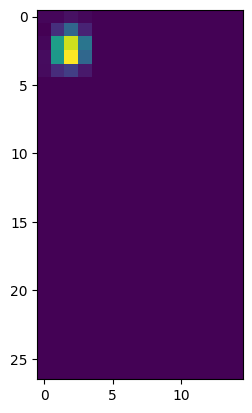

In [14]:
plt.imshow(df.BlobImage.iloc[20])

In [20]:
#Store the dataset
df.to_pickle("/content/drive/My Drive/full_preprocess_data.pkl")